# 홈런을 예측하는 예측 변수를 찾아보자

데이터셋 링크 : [kaggle 데이터셋 링크](https://www.kaggle.com/jcraggy/baseball)

선택 목적 : 확률과 통계의 스포츠 야구에서 홈런을 예측하는 변수들에 대한 궁금증  
모델 선택 : 분류 문제로의 접근 필요하다면 회귀로 확률적인 접근

In [135]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

df_train = pd.read_csv('archive/train.csv')
df_test = pd.read_csv('archive/test.csv')
df_park = pd.read_csv('archive/park_dimensions.csv')

df_train.shape, df_test.shape


((46244, 25), (65779, 24))

## Feature 설명 , (train.csv, test.csv)
+ bip_id : 유니크, 볼의 고유 식별자
+ game_date : 게임날짜
+ home_team : 홈팀 약어
+ away_team : 어웨이 팀 약어
+ Batter_team : 타자의 팀 약어
+ Batter_name : 타자 이름
+ pitcher_name : 투수 이름
+ Batter_id : 타자의 고유 식별자
+ pitcher_id : 투수의 고유 식별자
+ isbatterlefty : 타자가 좌타자 인지 여부
+ ispitcherlefty : 투수가 좌투수 인지 여부
+ bb_type : 타구 유형 분류
+ bearing : 배트를 떠나는 볼의 수평 방향
+ pitch_name : 투구 유형 (구종)
+ park : 구장의 식별자
+ inning : 게임 이닝 수
+ outswhenup : 현재 아웃 갯수
+ balls : 현재 볼 갯수
+ strikes : 현재 스트라이크 갯수
+ plate_x : 센터 기준 좌측(-) 우측(+) 볼의 위치 (feet)
+ plate_z : 홈 플레이트 기준 볼의 위치 (feet)
+ pitch_mph : 볼의 속도 (mile / hour)
+ launch_speed : 배트를 떠나는 공의 속도 (mile)
+ launch_angle : 배트를 떠나는 공의 수직 각도 (수평 기준)
+ ishomerun : 홈런의 여부

## Feature 설명 , (park_dimensions.csv)
+ park : 구장의 고유 식별자
+ NAME : 구장 이름
+ Cover : 지붕 또는 돔의 여부
+ LF_Dim : 왼쪽 필드 벽까지의 거리 (feet)
+ CF_Dim : 중심 필드 벽까지의 거리 (feet)
+ RF_Dim : 오른쪽 필드 벽까지의 거리 (feet)
+ LF_W : 왼쪽 필드 벽의 높이 (feet)
+ CF_W : 중앙 필드 벽의 높이 (feet)
+ RF_W :오른쪽 필드 벽의 높이 (feet)



In [136]:
df_train.head()

,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
0,1,2020-08-26,ARI,COL,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,line_drive,left,Slider,0,1,0,1,2,-0.15,1.97,87.8,108.9,9.0,0
1,2,2020-08-10,COL,ARI,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,line_drive,left,4-Seam Fastball,7,1,1,3,1,-0.71,2.88,95.2,NaN,18.0,0
2,3,2020-08-10,COL,ARI,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,popup,left,Slider,7,3,0,1,2,-0.54,1.75,86.5,75.0,49.0,0
3,4,2020-08-26,ARI,COL,COL,"blackmon, charlie","ray, robbie",453568,592662,1,1,fly_ball,right,Slider,0,1,0,0,2,-0.42,3.15,86.7,90.6,54.0,0
4,5,2020-08-10,COL,ARI,COL,"blackmon, charlie","ray, robbie",453568,592662,1,1,ground_ball,left,4-Seam Fastball,7,1,1,1,0,0.18,3.27,96.1,NaN,6.0,0


## target 은 홈런 여부를 보여주는 is_home_run 이다.
## 베이스라인 모델은 랜덤포레스트 평가지표는 f1 score 이다.

## EDA 전처리

In [137]:
# import pandas_profiling

# profile = df_train.profile_report()
# profile

In [138]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46244 entries, 0 to 46243
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bip_id            46244 non-null  int64  
 1   game_date         46244 non-null  object 
 2   home_team         46244 non-null  object 
 3   away_team         46244 non-null  object 
 4   batter_team       46244 non-null  object 
 5   batter_name       46244 non-null  object 
 6   pitcher_name      46244 non-null  object 
 7   batter_id         46244 non-null  int64  
 8   pitcher_id        46244 non-null  int64  
 9   is_batter_lefty   46244 non-null  int64  
 10  is_pitcher_lefty  46244 non-null  int64  
 11  bb_type           46238 non-null  object 
 12  bearing           46244 non-null  object 
 13  pitch_name        46244 non-null  object 
 14  park              46244 non-null  int64  
 15  inning            46244 non-null  int64  
 16  outs_when_up      46244 non-null  int64 

<ipython-input-138-be7869668cad>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_train.info(verbose=True, null_counts=True)


In [139]:
train.isnull().sum()

bip_id              0
game_date           0
home_team           0
away_team           0
batter_team         0
batter_id           0
pitcher_id          0
is_batter_lefty     0
is_pitcher_lefty    0
bb_type             0
bearing             0
pitch_name          0
park                0
inning              0
outs_when_up        0
balls               0
strikes             0
plate_x             0
plate_z             0
pitch_mph           0
launch_speed        0
launch_angle        0
is_home_run         0
dtype: int64

In [140]:
test.isnull().sum()

bip_id              0
game_date           0
home_team           0
away_team           0
batter_team         0
batter_id           0
pitcher_id          0
is_batter_lefty     0
is_pitcher_lefty    0
bb_type             0
bearing             0
pitch_name          0
park                0
inning              0
outs_when_up        0
balls               0
strikes             0
plate_x             0
plate_z             0
pitch_mph           0
launch_speed        0
launch_angle        0
dtype: int64

In [141]:
## 원본 데이터 보존
train = df_train
test = df_test
park = df_park

In [142]:
train['bb_type'].unique()

array(['line_drive', 'popup', 'fly_ball', 'ground_ball', nan],
      dtype=object)

In [143]:
# tain set 과 test셋 모두 동일하게 적용한다. (나중의 CV를 위해서)
# feet로 표기 되어있는 수치들을 미터로 바꾸어 준다.
# mile로 표기 되어있는 수치를 km/h 로 바꾸어 준다.

def unitChange_meter (x):
    x = x * 0.3048
    return x

train[['plate_x', 'plate_z']] = train[['plate_x', 'plate_z']].apply(unitChange_meter)
train[['pitch_mph', 'launch_speed']] = train[['pitch_mph', 'launch_speed']].apply(lambda x : x * 1.60934)

test[['plate_x', 'plate_z']] = test[['plate_x', 'plate_z']].apply(unitChange_meter)
test[['pitch_mph', 'launch_speed']] = test[['pitch_mph', 'launch_speed']].apply(lambda x : x * 1.60934)

park[['LF_Dim', 'CF_Dim', 'RF_Dim', 'LF_W', 'CF_W', 'RF_W']] = park[['LF_Dim', 'CF_Dim', 'RF_Dim', 'LF_W', 'CF_W', 'RF_W']].apply(lambda x: x * 0.3048)

# 컬럼명 변경
train.rename(columns= {'pitch_mph' : 'pitch_kph'})
test.rename(columns= {'pitch_mph' : 'pitch_kph'})

# bb_type 결측치 행 제거
train.dropna(subset=['bb_type'], inplace=True)
test.dropna(subset=['bb_type'], inplace=True)

# launch_speed, launch_angle 상당히 많은 결측치를 가지고 있기 때문에 평균으로 채움
train.fillna({'launch_speed': train['launch_speed'].mean(), 'launch_angle': train['launch_angle'].mean()}, inplace=True)
test.fillna({'launch_speed': test['launch_speed'].mean(), 'launch_angle': test['launch_angle'].mean()}, inplace=True)


In [144]:
print(train['launch_speed'].mode(),'\n', train['launch_angle'].mode())
print(test['launch_speed'].mode(), '\n', test['launch_angle'].mode())


0    141.683253
dtype: float64 
 0    12.477419
dtype: float64
0    142.581629
dtype: float64 
 0    12.413089
dtype: float64


In [145]:
## 투수 이름과 타자 이름은 필요없다고 판단되므로 drop
train = train.drop(['batter_name', 'pitcher_name'], axis=1)
test = test.drop(['batter_name', 'pitcher_name'], axis=1)

## feature 들을 조합하여 풀어 볼 질문들
+ 홈런을 치기 위한 평균 타구 스피드
+ 홈런을 치기 위한 발사각
+ 홈런이 많이 생산되는 구장
+ 타자의 평균 비거리와 홈런과의 상관관계
+ 당겨칠때와 밀어쳤을때의 홈런 생산량 차이
+ 타자가 몇번째 공을 친것인가?
+ 투수와 타자의 손이 반대일때 홈런이 더 많이 나오는가?
+ 같은 투수와의 시간 많아 질 수록 홈런 생산량이 늘어=나는가?
+ 파울이 아닌 외야로 공을 많이 보내는 타자는 홈런 확률이 더 늘어 나는가?
+ 구종/구속과의 홈런의 확률

### 야구장 규격
+ 각 루간 거리 : 27.431 m
+ 다이아몬드 대각선 거리 : 38.79 m

### 타겟의 분포 확인

In [146]:
train['is_home_run'].value_counts()

0    43791
1     2447
Name: is_home_run, dtype: int64

<AxesSubplot:xlabel='is_home_run', ylabel='count'>

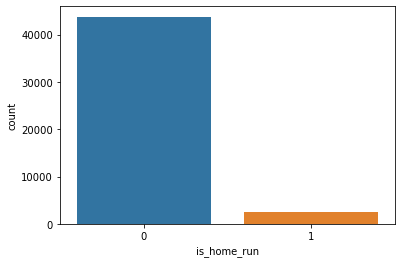

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data =train, x = 'is_home_run')

### 데이터를 훈련/검증 세트로 나누어 준다.

In [148]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.75, test_size=0.25, random_state=74)
train.shape, val.shape

((34678, 23), (11560, 23))

### 베이스라인 모델 적용

In [178]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

target = 'is_home_run'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, random_state = 222, oob_score = True)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.9600346020761246


In [179]:
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10933
           1       0.82      0.34      0.48       627

    accuracy                           0.96     11560
   macro avg       0.89      0.67      0.73     11560
weighted avg       0.96      0.96      0.95     11560



In [180]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
f1_score(y_val, y_pred)

0.47855530474040636

### Confusion Matrix

Text(0.5, 1.0, 'Confusion matrix, n = 11560')

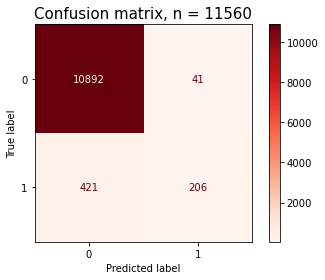

In [160]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Reds,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [169]:
## 변수 중요도 확인
for f in range(X_train.shape[1]):
    print(X_train.columns[f], pipe[1].feature_importances_[f])

bip_id 0.028731526987622834
game_date 0.02126520881925078
home_team 0.015608935884764237
away_team 0.017379606678969543
batter_team 0.016678403974186136
batter_id 0.02549418271955943
pitcher_id 0.02478599600510428
is_batter_lefty 0.009135902853107412
is_pitcher_lefty 0.0030140667369190563
bb_type 0.10169217802851187
bearing 0.02070809525069478
pitch_name 0.010275176285939418
park 0.015480113499533304
inning 0.013623845653994864
outs_when_up 0.005281566711381857
balls 0.007859859654712012
strikes 0.006211992374079012
plate_x 0.030502352842108546
plate_z 0.030030112326007434
pitch_mph 0.026657035007276012
launch_speed 0.3233103486004437
launch_angle 0.24627349310583357


### 특성 중요도 시각화

Text(0.5, 0, 'Random Forest Feature Importance')

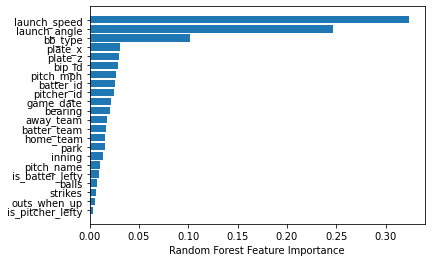

In [170]:
sorted_idx = pipe[1].feature_importances_.argsort()
plt.barh(features[sorted_idx], pipe[1].feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

f1 score가 0.47 정도 밖에 나오지 않았다.  
특성 중요도에서는 발사 속도, 발사 각도, 타구 유형 순위로 중요도를 나타내었다.

### 랜덤 포레스트 하이퍼 파라미터 튜닝
랜덤 포레스트의 예측 능력을 튜닝  
ordinal 인코딩에서 target 인코딩으로 바꿈

In [187]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline

target = 'is_home_run'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe_rf2 = make_pipeline(
    TargetEncoder(),
    RandomForestClassifier(n_jobs=-1, random_state = 222, oob_score = True, n_estimators=5000, max_depth=15)
)

pipe_rf2.fit(X_train, y_train)
print('검증 정확도: ', pipe_rf2.score(X_val, y_val))

C:\Users\comic\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.960553633217993


In [188]:
y_pred = pipe_rf2.predict(X_val)
f1_score(y_val, y_pred)

0.47826086956521735

### el5 라이브러리를 이용한 특성 중요도 계산

In [189]:
import eli5
from eli5.sklearn import PermutationImportance

pipe_rf2.named_steps

{'targetencoder': TargetEncoder(cols=['game_date', 'home_team', 'away_team', 'batter_team',
                     'bb_type', 'bearing', 'pitch_name']),
 'randomforestclassifier': RandomForestClassifier(max_depth=15, n_estimators=5000, n_jobs=-1,
                        oob_score=True, random_state=222)}

In [202]:
permuter = PermutationImportance(
    pipe_rf2.named_steps['randomforestclassifier'],
    scoring='f1', 
    n_iter=20,
    random_state=74
)


In [203]:
X_val_transformed = pipe_rf2.named_steps['targetencoder'].transform(X_val)

permuter.fit(X_val_transformed, y_val);


import webbrowser
url='https://freesound.org/data/previews/219/219244_4082826-lq.mp3'
webbrowser.open(url)

True

In [204]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

batter_team        -0.004002
park               -0.001962
pitch_mph          -0.000563
pitcher_id         -0.000528
balls              -0.000479
is_pitcher_lefty   -0.000247
inning             -0.000195
strikes             0.000023
away_team           0.000089
is_batter_lefty     0.000731
outs_when_up        0.000737
batter_id           0.000778
pitch_name          0.000931
bip_id              0.001065
game_date           0.001264
home_team           0.003379
plate_z             0.006286
plate_x             0.012205
bearing             0.018120
bb_type             0.215655
launch_angle        0.252886
launch_speed        0.356882
dtype: float64

In [210]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.3569 ± 0.0308,launch_speed
0.2529 ± 0.0304,launch_angle
0.2157 ± 0.0300,bb_type
0.0181 ± 0.0117,bearing
0.0122 ± 0.0075,plate_x
0.0063 ± 0.0078,plate_z
0.0034 ± 0.0051,home_team
0.0013 ± 0.0064,game_date
0.0011 ± 0.0045,bip_id
0.0009 ± 0.0055,pitch_name


**feature_importances_ 와 달리 PermutationImportance 에서는 (bearing) 타구의 방향이 중요한 특성으로 올라온 것을 알 수 있다**